In [1]:
# Clone the repo to make its file available for Google Colab
!git clone https://github.com/BROSE-Uninc/SSF2021.git

Cloning into 'SSF2021'...


In [2]:
# Install the packages
!pip install ema_workbench mesa ipyparallel SALib &> /dev/null

The syntax of the command is incorrect.


### EMA imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from ema_workbench import (ReplicatorModel, RealParameter, BooleanParameter, IntegerParameter, 
Constant, TimeSeriesOutcome, perform_experiments, save_results, ema_logging)

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### Define Mesa model

In this part, we define the virus on network as a function. This function will be used by the EMA workbench later on.

In [4]:
# setting up the virus on network model simulation as a function
def model_virus_on_network(num_nodes=1, 
                            avg_node_degree=1, 
                            initial_outbreak_size=1, 
                            virus_spread_chance=1, 
                            virus_check_frequency=1, 
                            recovery_chance=1, 
                            gain_resistance_chance=1,
                            steps=10):
    
    # importing the virus on network example from mesa (copied in the repository)
    from src import model # for jupyter
#     import model # for colab
    
    #initialising the model
    virus_on_network = model.VirusOnNetwork(num_nodes=num_nodes, 
                                avg_node_degree=avg_node_degree, 
                                initial_outbreak_size=initial_outbreak_size, 
                                virus_spread_chance=virus_spread_chance, 
                                virus_check_frequency=virus_check_frequency, 
                                recovery_chance=recovery_chance, 
                                gain_resistance_chance=gain_resistance_chance)
    
    # running mode for a number of steps
    virus_on_network.run_model(steps)
    # collecting and saving the final states of the model
    outcomes = virus_on_network.datacollector.get_model_vars_dataframe()
    
    # returning all of the states of the model
    return {'TIME':list(range(steps + 1)),
            "Infected": outcomes["Infected"].tolist(),
            "Susceptible": outcomes["Susceptible"].tolist(),
            "Resistant": outcomes["Resistant"].tolist()}
    

### Test Mesa model

This part illustrates how the virus on network mesa model is run using Python.

In [6]:
# running the model for 10 steps, with 20 nodes, ...
model_virus_on_network(num_nodes=20, 
                            avg_node_degree=3, 
                            initial_outbreak_size=1, 
                            virus_spread_chance=0.4, 
                            virus_check_frequency=0.2, 
                            recovery_chance=0.4, 
                            gain_resistance_chance=0.3,
                            steps=10)

{'TIME': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Infected': [1, 5, 13, 15, 15, 17, 17, 17, 15, 13, 13],
 'Susceptible': [19, 15, 7, 5, 5, 3, 2, 2, 3, 4, 3],
 'Resistant': [0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 4]}

### Design EMA experiments

In this part, we define the experiments. First, we initialise the workbench, then we define the parameters that need to change from experiment to experiment, we define the constant parameters (number of steps and initial outbreak) and finally we define the output parameters.

In [7]:
# loading the model into the EMA workbench
model = ReplicatorModel('virusnetwork', function=model_virus_on_network)

In [8]:
# defining ranges for the parameters to be varied
model.uncertainties = [IntegerParameter("num_nodes", 10, 100),
                       IntegerParameter("avg_node_degree", 2, 8),
                        RealParameter("virus_spread_chance", 0.1, 1),
                        RealParameter("virus_check_frequency", 0.1, 1),
                        RealParameter("recovery_chance", 0.1, 1),
                        RealParameter("gain_resistance_chance", 0.1, 1)]

In [9]:
# defining the parameters that will remain constant
model.constants = [Constant("initial_outbreak_size", 1),
                  Constant('steps', 30)]

In [10]:
# defining the outputs of interests from the model
model.outcomes = [TimeSeriesOutcome('TIME'),
                TimeSeriesOutcome('Infected'),
                 TimeSeriesOutcome('Susceptible'),
                 TimeSeriesOutcome('Resistant')]

In [11]:
# defining the number of replications
model.replications = 10

### Perform EMA experiments

In this part we run the EMA experiments using the previously set parameters. We then store the results.

In [12]:
# running the EMA experiments with the aforementioned parameters and outputs
results = perform_experiments(model, 100)

# opening the results
experiments, outcomes = results

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [ ]:
# TODO:
# Save and load outcomes

### Process outcomes
In this part we reshape the results so that they can be more easily plotted later on.

In [14]:
outcomes[random.choice(list(outcomes))].shape

(100, 10, 31)

In [15]:
#get shape of every outcome (should all be identical?)
# for k in list(outcomes):
#     print(outcomes[k].shape)

In [16]:
outcomes_2D = {key:np.mean(outcomes[key],axis=1) for key in outcomes.keys()}
results_2D = (experiments.copy(), outcomes_2D)

In [17]:
outcomes_2D[random.choice(list(outcomes))].shape

(100, 31)

### Visualize outcomes
In this part, we plot the three different model outcomes.

In [30]:
from ema_workbench.analysis.plotting import lines

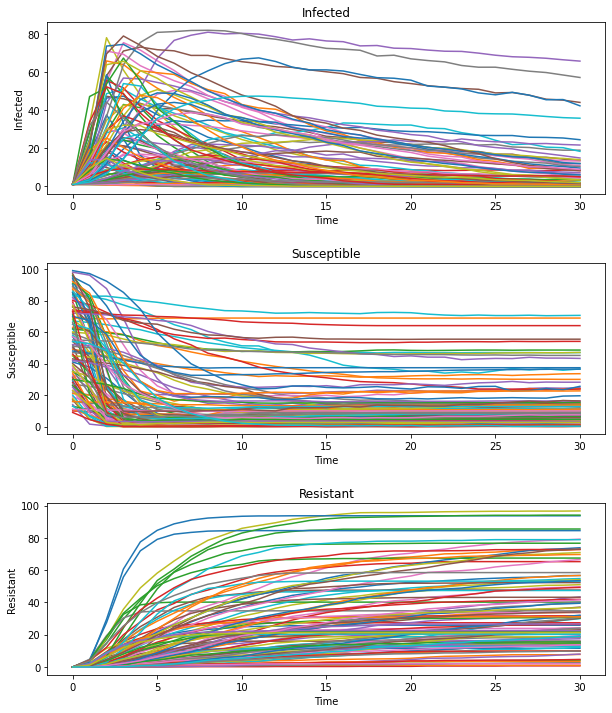

In [21]:
# plotting all of the results
plt.rcParams['figure.figsize'] = [10, 12]

figure = lines(experiments, outcomes_2D) #show lines, and end state density
plt.show()

### Sensitivity analysis

In [ ]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [22]:
sa_results = perform_experiments(model, scenarios=100, uncertainty_sampling='sobol')
sa_experiments, sa_outcomes = sa_results

[MainProcess/INFO] performing 1400 scenarios * 1 policies * 1 model(s) = 1400 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 980 cases completed
[MainProcess/INFO] 1120 cases completed
[MainProcess/INFO] 1260 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] experiments finished


##### Sample size for Sobol
To calculate first-order, second-order and total sensitivity indices, 
this gives a sample size of n(2p+2), where p is the number of input parameters, 
and n is a baseline sample size which should be large enough to stabilize the estimation of the indices.
from https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html#Using-SALib-for-sensitivity-analysis

In [23]:
# selecting only the first axis of the result array (why?)
sa_outcomes_2D = {key:np.mean(sa_outcomes[key],axis=1) for key in sa_outcomes.keys()}
sa_results_2D = (sa_experiments.copy(), sa_outcomes_2D)

In [24]:
# normalising the number of resistant agents
normalized_resistant = (sa_outcomes_2D['Resistant'][:,-1] / sa_experiments['num_nodes']).to_numpy()
normalized_resistant

array([0.5877193 , 0.31929825, 0.83333333, ..., 0.46315789, 0.575     ,
       0.56578947])

In [25]:
# performing the sobol analysis
sa_problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(sa_problem, normalized_resistant,
                   calc_second_order=True, print_to_console=False)

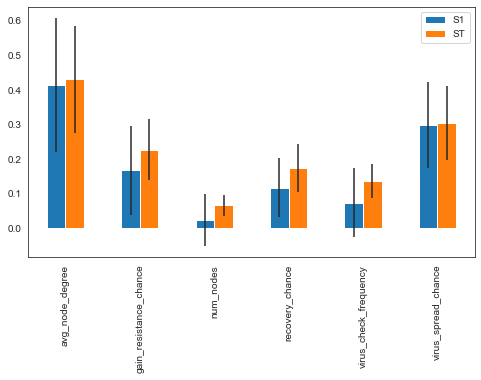

In [26]:
# plotting the results from the analysis
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=sa_problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [27]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=sa_problem['names'])

In [28]:
from src.plot import plot_sobol_indices

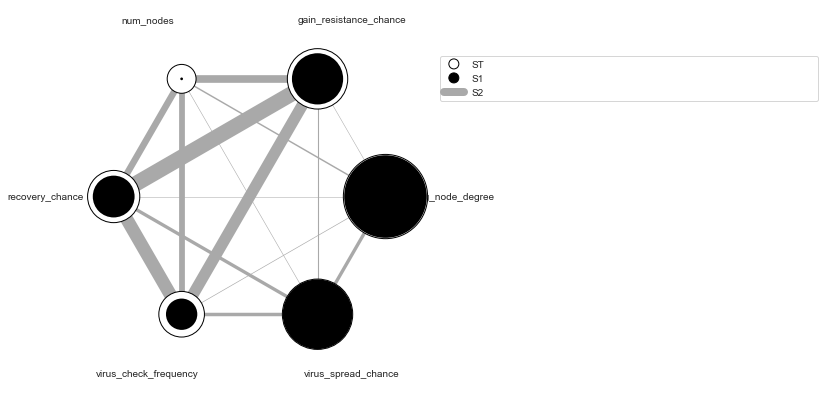

In [29]:
sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, sa_problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()